In [1]:
# %matplotlib inline
import gym, math, glob
import numpy as np

import cv2

from timeit import default_timer as timer
from datetime import timedelta

from collections import deque
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from IPython import display
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# from utils.wrappers import *
# from agents.DQN import Model as DQN_Agent
# from utils.ReplayMemory import ExperienceReplayMemory

#from utils.Replay.ipynb import ReplayBuffer
from utils.hyperparameters import Config
from utils.plot import plot_all_data
import Game.tetris_fun as game

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Solution for error: no available video device
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [5]:
class ReplayBuffer:
    
    def __init__(self, size, screen_shape=(84, 84)):
        self.size = size
        self.screen_shape = screen_shape
        self.num_in_buffer = 0
        self.screens = deque(maxlen=self.size)
        self.actions = deque(maxlen=self.size)
        self.rewards = deque(maxlen=self.size)
#          self.next_screens = deque(maxlin=self.size)
        self.terminal = deque(maxlen=self.size)
        
    def push(self, screen, action, reward, terminal):
        self.screens.append(screen)
        self.actions.append(action)
        self.rewards.append(reward)
        self.terminal.append(terminal)
#         self.next_screens.append(next_screens)
        
        self.num_in_buffer = len(self.screens)
#         print("buffer num ", self.num_in_buffer)
#         print("action num ", len(self.actions))
#         print("reward num ", len(self.rewards))
#         print("ter num ", len(self.terminal))
#         print(self.actions)
        
    def can_sample(self, batch_size):
        """Returns true if `batch_size` different transitions can be sampled from the buffer."""
        return batch_size + 1 <= self.num_in_buffer
    
    def _encode_sample(self, idxes):
        # Return batch data for screens, actions, rewards, next screens and terminal info
        # one screen state corresponding to one action by default, needing to consider grouped screens and actions
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        obs_batch      = torch.from_numpy(np.concatenate([self.screens[idx] for idx in idxes], 0)).to(device)
        act_batch      = torch.Tensor([[self.actions[idx]] for idx in idxes]).type(torch.long).to(device)
        rew_batch      = torch.Tensor([self.rewards[idx] for idx in idxes]).to(device)
        next_obs_batch = torch.from_numpy(np.concatenate([self.screens[idx + 1] for idx in idxes], 0)).to(device)
        done_mask      = np.array([1.0 if self.terminal[idx] else 0.0 for idx in idxes], dtype=np.float32)
        
        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask
        
    
    def sample(self, batch_size):
#         assert self.can_sample(batch_size)
        inds = random.sample(range(self.num_in_buffer-1), batch_size)  # avoid sampling the last item and leading to index out of range for next state
#         print("ind ", inds)
        
        return self._encode_sample(inds)
        

In [6]:
# The DQN model
class DQN(nn.Module):
    def __init__(self, num_actions, in_channels=3, screen_shape=(84, 84)):
        super(DQN, self).__init__()
        in_channels = in_channels
        num_actions = num_actions
        screen_shape = screen_shape
        h = screen_shape[0]
        w = screen_shape[1]
        
        
        # could add batchnorm2d layers after each covnet if data volume is too large
        # see: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(h, 8, 4), 4, 2), 3, 1)

        self.fc1 = nn.Linear(convw * convh * 64, 512)
        self.fc2 = nn.Linear(512, num_actions)
        
        
    def forward(self, x):
        x = self.conv1(x)
#         print("forward", x.size())
        x = F.relu(x)
#         x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # reshape the tensor to one dimension for fc layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        return self.fc2(x)
    
    def conv2d_size_out(self, size, kernel_size, stride, padding_size=0):
        return (size + 2 * padding_size - (kernel_size - 1) - 1) // stride  + 1
    

m = DQN(6, 1, (84, 84))
input1 = torch.randn(1, 1, 84, 84)
print(input1.dtype)
output = m(input1)

x_t = np.array([1, 2, 255, 3, 8, 255], dtype=np.double)
# x_t = np.array([0.0 if x//255 < 1 else 255.0 for x in x_t])
print(x_t)

    

torch.float32
[  1.   2. 255.   3.   8. 255.]


In [7]:
# Hyperparameters and utilities

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TARGET_UPDATE = 10
lr = 0.001
memory_size = 100000
num_episodes = 1000


def get_action(state, policy_net):
    # Return a number indicating the pos of 1 in the array for a action
    steps_done = 0
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state)
#             print("act size", action.size())
#             print(action)
#             action = action.max(1)[1][0]
            action = action.max(1)[1]
#             print("act num size", action.size())
            return action
    else:
        action = torch.Tensor([random.randint(0, 5)])
#         print("rand int size ", action.size())
        return action
    
def get_act_array(act_num):
    act_num = int(act_num.item())
#     print("act_num", act_num)
    action = np.zeros(6, dtype=int)
    action[act_num] = 1
    return action

def get_next_qs(target_net, next_obs_batch, done_mask, BATCH_SIZE):
    not_terminal = np.where(done_mask==0.0)
    not_terminal_states = next_obs_batch[not_terminal]
    values = torch.zeros(BATCH_SIZE)
    values[not_terminal] = target_net(not_terminal_states).max(dim=1)[0].detach()
    return values
            
def preprocess(image, shape=(84,84)):
    pass

def plot_results(episode, episode_scores, losses):
    display.clear_output(wait = True)
    episode += 1
    f, ax = plt.subplots(1, 2, figsize=(12, 10))
    plt.subplot(1, 2, 1)
    plt.title("Scores: %s, episode %s" % (episode_scores[episode-1], episode))
    plt.xlabel("Episode")
    plt.xlim((1, episode))
    plt.ylim(bottom=-1)
    plt.plot(episode_scores[episode-1])
    
    plt.subplot(1, 2, 2)
    plt.title("Losses: episode %s" % episode)
    plt.xlabel("Step")
    plt.plot(losses)
    plt.show()
    

def plot_durations(episode_durations, average_num=100):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= average_num:
        means = durations_t.unfold(0, average_num, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(average_num-1), means))
        plt.plot(means.numpy())
        
    plt.show()
#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
    


In [3]:


"""BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TARGET_UPDATE = 10
lr = 0.001
memory_size = 100000
num_episodes = 1000"""


def train(env, num_actions, in_channels, memory_size=100000, screen_shape=(84, 84), target_update=10, 
          BATCH_SIZE=128, GAMMA=0.999, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=0.001, lr=0.001, num_episodes=1000,
         save_point=[500, 1000, 3000, 5000, 10000, 50000, 100000]):
    env = env
    saving_path = './model_saving'
    save_point = save_point
    
    # if GPU is available, use it otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(num_actions, in_channels).to(device)
    target_net = DQN(num_actions, in_channels).to(device)
    
    # set weight and bias of target net as policy net
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
    
    memory = ReplayBuffer(memory_size, screen_shape)
    
    episode_durations = []
    scores = []
    losses = []
    
    for episode in range(num_episodes):
        start_act = np.zeros(num_actions)
        x_t, r_0, terminal = env.frame_step(start_act)
        
#         x_t = cv2.cvtColor(cv2.resize(x_t, (84, 84)), cv2.COLOR_BGR2GRAY)  # resize the screen and convert color to gray
#         ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)  # set the background to black and tetriminos to white
# #         s_t = np.stack((x_t, x_t, x_t, x_t), axis = 2)
#         print("episode", episode)
        timestep = 0
        
        while True:
            timestep += 1
            
            x_t = cv2.cvtColor(cv2.resize(x_t, (84, 84)), cv2.COLOR_BGR2GRAY)
            ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)
#             x_t = np.array([0.0 if (x//255) < 1 else 255.0 for x in x_t])
            
#             x_t = np.array(x_t, dtype=np.double)  # image value must be float cause net needs the values to calculate gradients
            x_t = x_t.copy().astype(np.float32)
            x_t = torch.from_numpy(x_t).unsqueeze(0)
            x_t = x_t.unsqueeze(0)
            
#             print("time ", timestep)
            act_num = get_action(x_t, policy_net)
            act = get_act_array(act_num)
            x_t1, r_1, terminal = env.frame_step(act)
            
            memory.push(x_t, act_num, r_1, terminal)
            
            x_t = x_t1
            
            if memory.can_sample(BATCH_SIZE):
                obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = memory.sample(BATCH_SIZE)
#                 print("obs ", obs_batch.size())
#                 print("act ", act_batch.size())
#                 print("rew ", rew_batch.size())
                
                curr_qs = policy_net(obs_batch)
#                 print("curr size ", curr_qs.size())
                curr_qs = policy_net(obs_batch).gather(1, act_batch)
                next_qs = get_next_qs(target_net, next_obs_batch, done_mask, BATCH_SIZE)
#                 print("next qs ", next_qs.size())
#                 print("current qs ", curr_qs.size())
#                 print(curr_qs[0])
                
                target_q_values = rew_batch + GAMMA * next_qs
#                 print("target q ", target_q_values.size())
                
                criterion = nn.MSELoss()
                loss = criterion(curr_qs, target_q_values.unsqueeze(1))
                losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if terminal:
                episode_durations.append(timestep)
                scores.append(r_1)
                plot_results(episode, scores, losses)
                plot_durations(episode_durations)
                break
                
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
                
            if episode in save_point:
                torch.save(self.policy_net, "%s/%s_%s.pth" % (saving_path, "DQN", episode))
                torch.save({
                            'episode': episode,
                            'model_state_dict': policy_net.state_dict(),
                            'target_state_dict': target_net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss,
                            }, saving_path)   # save for later training
                
        env.reinit()
                
            
                
            
                
            
            
            
        
        
    
    
    
x = np.arange(8)
print(x)
y = x.reshape((4,2,1))
print(y)

[0 1 2 3 4 5 6 7]
[[[0]
  [1]]

 [[2]
  [3]]

 [[4]
  [5]]

 [[6]
  [7]]]


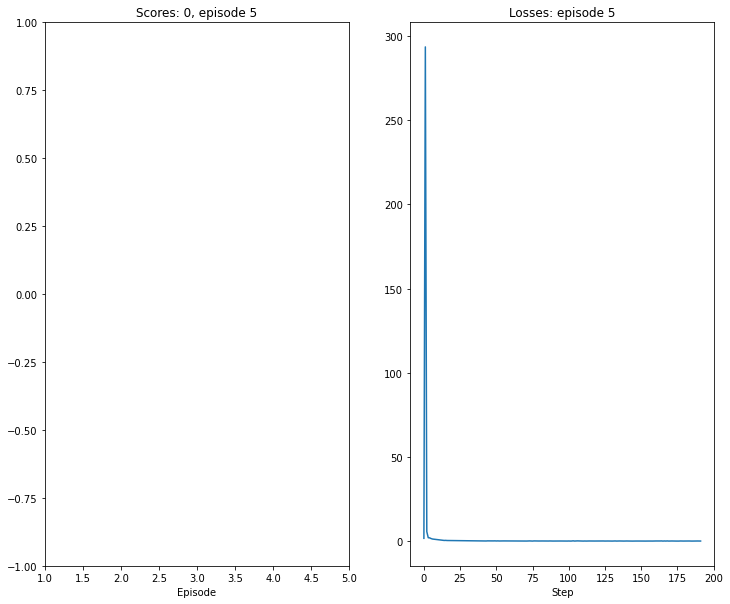

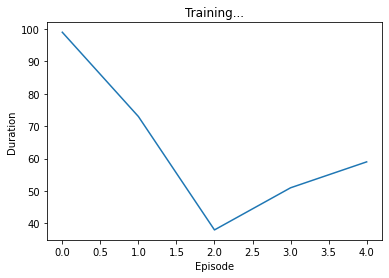

In [ ]:

num_actions = 6
in_channels = 1
screen_shape = (84, 84)

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TARGET_UPDATE = 10
lr = 0.001
memory_size = 100000
num_episodes = 1000

env = game.GameState()
train(env, num_actions, in_channels, memory_size, screen_shape, save_point=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])